# Applicative Machine Learning <br/> Final Project - Vehicle Identification

## About

* This notebook serves the final project for the course Applicative Machine Learning - K30 IT Master class - HCMUS.
* Jul, 2021.

* This project aims at solving vehicle (mainly cars) recognition/identification through transfer learning & fine tuning on contemporary state-of-the-art backbones pre-trained on ImageNet.

* **Contact:**
    * Lâm Lê Thanh Thế
    * ID: 20C11053
    * Email: lamlethanhthe@gmail.com, 20c11053@student.hcmus.edu.vn
    * Phone: 0979.093.710
    
* *For further info please read the `README.md` file or the `...Report.docx` (in Vietnamese)!*

## Utils

Including helpful functions and code to setup different environments such as Google Colab or Kaggle.

### Shared

In [1]:
import csv
import pickle
import matplotlib.pyplot as plt

DAT_FOLDER = './data'
CLASS_FILE = DAT_FOLDER + '/names.csv'

SEED = 1108

def getClasses(csvPath = CLASS_FILE):
    with open(csvPath) as f:
        reader = csv.reader(f)
        classes = []
        for row in reader:
            c = row[0].replace('/', '-')
            classes.append(c)
    return classes

def saveHist(path, hist):
    with open(path, 'wb') as f:
        pickle.dump(hist.history, f)
        
def getHist(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def plotTrainResult(hists):
    acc = []
    loss = []
    valAcc = []
    valLoss = []
    
    for hist in hists:
        acc.extend(hist['accuracy'])
        loss.extend(hist['loss'])
        valAcc.extend(hist['val_accuracy'])
        valLoss.extend(hist['val_loss'])
        
    plt.figure(figsize = (8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label = 'Training Accuracy')
    plt.plot(valAcc, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label = 'Training Loss')
    plt.plot(valLoss, label = 'Validation Loss')
    plt.legend(loc = 'upper right')
    plt.title('Training and Validation Loss')

    plt.xlabel('epoch')
    plt.show()

### Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Master Tmp/AML/Project'

Mounted at /content/drive
/content/drive/MyDrive/Master Tmp/AML/Project


In [ ]:
# Only RUN ONCE to extract data into Google Drive
# !unzip -qq -n {'./data.zip'} -d {'./'} # qq: very quiet

### Kaggle

In [4]:
!conda install -y gdown

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.0.12            |     pyh9f0ad1d_0          10 KB  conda-forge
    gdown-3.13.0               |     pyhd8ed1ab_0          12 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          22 KB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.0.12-pyh9f0ad1d_0
  gdown              conda-forge/noarch::gdown-3.13.0-pyhd8ed1ab_0



filelock-3.0.12      | 10 KB     | ##################################### | 100% 
gdown-3.1

In [5]:
# Get ID from sharing the file in Drive

# Download data.zip
!gdown https://drive.google.com/uc?id=1JDkVt5jwAFouI1C7Vt3LtsvGrTVjxbT2
    
# Extras: models + CSVs
!gdown https://drive.google.com/uc?id=1qbrIc1UyJvTFcdMeT74UhaFr7ax45Mf1 

Downloading...
From: https://drive.google.com/uc?id=1JDkVt5jwAFouI1C7Vt3LtsvGrTVjxbT2
To: /kaggle/working/data.zip
1.96GB [00:11, 172MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1qbrIc1UyJvTFcdMeT74UhaFr7ax45Mf1
To: /kaggle/working/kaggle.zip
100%|████████████████████████████████████████| 125k/125k [00:00<00:00, 58.1MB/s]


In [ ]:
!unzip -qq -n {'./kaggle.zip'} -d {'./'}
!unzip -qq -n {'./data.zip'} -d {'./'}

!mv ./kaggle/models ./
!mv ./kaggle/train.csv data
!mv ./kaggle/test.csv data

In [ ]:
# Use after training on Kaggle draft session to download the models

!zip -r fromKaggle.zip models
from IPython.display import FileLink
FileLink('./fromKaggle.zip') 

## Data Transformation

* [Original](http://ai.stanford.edu/~jkrause/cars/car_dataset.html) -> very slow download and only give Matlab label file.
* [Kaggle Alternative](https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder?select=car_data) -> images are put into subfolders based on class + some helpful CSVs

=> **Transformation:**
* Merge all images into one set
* Create CSV for train & test: 85%:15% stratified

In [ ]:
import os
import shutil

In [ ]:
DAT_FOLDER = './data'
TEST_FOLDER = DAT_FOLDER + '/car_data/car_data/test'
TRAIN_FOLDER = DAT_FOLDER + '/car_data/car_data/train'
TARGET_FOLDER = DAT_FOLDER + '/imgs'

In [ ]:
classes = getClasses()
print(f'Got {len(classes)} classes')

Got 196 classes


### Sample Count Distribution

In [12]:
import os 

classes = getClasses()

counts = []
for c in classes:
    counts.append(len(os.listdir(f'./data/imgs/{c}')))
print(counts)

[89, 64, 86, 84, 81, 89, 78, 90, 82, 66, 76, 73, 82, 85, 86, 87, 81, 85, 81, 92, 84, 85, 79, 90, 79, 68, 71, 82, 85, 83, 88, 83, 84, 89, 82, 82, 77, 81, 73, 78, 71, 69, 92, 89, 65, 87, 70, 85, 75, 84, 86, 82, 89, 80, 79, 93, 75, 88, 89, 73, 86, 74, 88, 59, 90, 83, 77, 80, 76, 85, 70, 90, 89, 87, 88, 87, 81, 75, 97, 86, 90, 90, 81, 84, 87, 85, 88, 79, 88, 82, 77, 80, 78, 87, 91, 82, 84, 92, 55, 67, 84, 78, 79, 85, 87, 83, 89, 88, 89, 86, 84, 91, 85, 90, 90, 75, 85, 83, 136, 85, 89, 80, 89, 78, 87, 84, 82, 78, 77, 82, 84, 87, 84, 67, 84, 48, 87, 79, 85, 84, 68, 65, 80, 93, 88, 86, 89, 90, 85, 72, 87, 71, 89, 85, 85, 78, 73, 58, 72, 88, 96, 91, 73, 87, 89, 82, 95, 84, 77, 88, 92, 88, 87, 82, 61, 77, 88, 83, 90, 85, 76, 92, 84, 81, 77, 77, 87, 87, 81, 86, 92, 85, 83, 91, 86, 80]


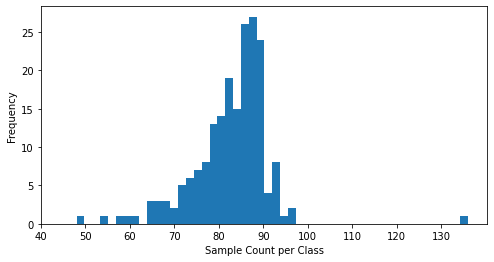

In [24]:
import matplotlib.pyplot as plt 
import numpy as np

plt.figure(figsize = (8, 4))
plt.hist(counts, bins = 50)
plt.xticks(np.arange(40, 140, 10))
plt.xlabel('Sample Count per Class')
plt.ylabel('Frequency')
plt.show()

### Restructuring

In [ ]:
for c in classes:
    os.makedirs(TARGET_FOLDER + '/' + c, exist_ok=True)

In [ ]:
suffixes = ['tr', 't']
folders = [TRAIN_FOLDER, TEST_FOLDER]

count = 0
for f, s in zip(folders, suffixes):
    for c in os.listdir(f):
        cpath = f + '/' + c
        for i in os.listdir(cpath):
            ipath = cpath + '/' + i
            name, ext = os.path.splitext(i)
            shutil.move(ipath, TARGET_FOLDER + f'/{c}/{name}_{s}{ext}')
            count += 1

print(f'Processed {count} images')

Processed 16185 images


### Train Test Spliting

In [ ]:
X = []
y = []
for i in range(len(classes)):
    c = classes[i]
    cpath = TARGET_FOLDER + '/' + c
    for img in os.listdir(cpath):
        X.append((cpath + '/' + img)[7:])
        y.append(i)
print(f'Retrieved info for {len(X)} images')

Retrieved info for 16185 images


In [ ]:
from sklearn.model_selection import train_test_split

TEST_RATIO = 0.15

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y,
    test_size = TEST_RATIO,
    random_state = SEED,
    shuffle = True,
    stratify = y
)

In [ ]:
paths = [DAT_FOLDER + f'/{i}' for i in ['train.csv', 'test.csv']]
Xs = [Xtrain, Xtest]
ys = [ytrain, ytest]

for path, X, y in zip(paths, Xs, ys):
    with open(path, mode='w') as f:
        writer = csv.writer(f)
        writer.writerow(['image', 'label'])
        for img, label in zip(X, y):
            writer.writerow([img, str(label)])

## Training & Evaluating

### Setup

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from tensorflow.keras.applications import MobileNetV2, Xception
from tensorflow.keras.losses import categorical_crossentropy # This is the loss func, not the class
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

N_SAMPLES = 16185
N_CLASS = 196
LABEL_SMOOTH = 0.1

META = {
    1: {'f': MobileNetV2, 'imgSize': (224, 224), 'dropRate': 0.2, 'batchSize': 128},
    2: {'f': Xception, 'imgSize': (299, 299), 'dropRate': 0.4, 'batchSize': 48},
}

baseModelChoice = 2

baseModelF = META[baseModelChoice]['f']
IMG_SIZE = META[baseModelChoice]['imgSize']
BATCH_SIZE = META[baseModelChoice]['batchSize']
DROP_RATE = META[baseModelChoice]['dropRate']

classes = getClasses()
print(f'# Classes: {len(classes)}')

# Sparse categorical crossentropy with Label smoothing
def scce_with_ls(y, y_hat):
    y = tf.one_hot(tf.cast(y, tf.int32), N_CLASS)
    y = tf.squeeze(y, axis = 1)
    return categorical_crossentropy(y, y_hat, label_smoothing = LABEL_SMOOTH)

def getCallbacks(chkpath, reduceLRpatience = 4, earlyStopPatience = 7):
    checkpoint = ModelCheckpoint(
        filepath = chkpath,
        save_weights_only = True,
        monitor = 'val_accuracy',
        mode = 'max',
        save_best_only = True
    )

    reduceLR = ReduceLROnPlateau(
        monitor = 'val_accuracy',
        factor = 0.2,
        patience = reduceLRpatience, # epochs
        min_lr = 1e-6
    )
    
    early_stopping = EarlyStopping(monitor = 'val_loss', patience = earlyStopPatience)
    
    return [checkpoint, reduceLR, early_stopping]

### Loading Train & Val Data

In [6]:
import pandas as pd

DAT_FOLDER = './data'
DAT_PATH = DAT_FOLDER + '/imgs'
TRAIN_CSV = DAT_FOLDER + '/train.csv'

traindf = pd.read_csv(TRAIN_CSV)
print(f'Number of train samples: {len(traindf.index)}')
traindf.head()

Number of train samples: 13757


,image,label
0,imgs/Bugatti Veyron 16.4 Coupe 2009/04787_t.jpg,45
1,imgs/Jaguar XK XKR 2012/05153_tr.jpg,143
2,imgs/Audi TTS Coupe 2012/01464_t.jpg,13
3,imgs/Ford E-Series Wagon Van 2012/01839_t.jpg,115
4,imgs/Ferrari California Convertible 2012/02521...,101


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

VAL_RATIO = 0.15

def getTrainValSet(seed=SEED):
    trainGen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        rotation_range=15, # in degree
        brightness_range=[0.8, 1.2], # 1 = original
        shear_range=0.15,
        validation_split=VAL_RATIO
    )

    trainSet = trainGen.flow_from_dataframe(
        dataframe=traindf, 
        directory=DAT_FOLDER, 
        x_col='image', 
        y_col='label', 
        class_mode='raw', 
        shuffle=True,
        seed=seed,
        batch_size=BATCH_SIZE,
        target_size=IMG_SIZE,
        color_mode='rgb',
        subset='training'
    )
    
    valGen = ImageDataGenerator(
        validation_split=VAL_RATIO
    )

    valSet = valGen.flow_from_dataframe(
        dataframe=traindf, 
        directory=DAT_FOLDER, 
        x_col='image', 
        y_col='label', 
        class_mode='raw', 
        shuffle=False,
        seed=seed, # MUST USE THE SAME SEED as the train set 
        batch_size=BATCH_SIZE,
        target_size=IMG_SIZE,
        color_mode='rgb',
        subset='validation'
    )
    
    return trainSet, valSet

In [7]:
trainSet, valSet = getTrainValSet()

Found 11694 validated image filenames.
Found 2063 validated image filenames.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualizePreTrain(datSet):
    plt.figure(figsize=(16, 16))
    i = 0
    for images, labels in datSet:
        for image, label in zip(images, labels):
            image = image / 255
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(image)
            plt.title(classes[label])
            plt.axis("off")
            i += 1
            if i >= 9:
                break 
        if i >= 9:
            break 
    plt.show()

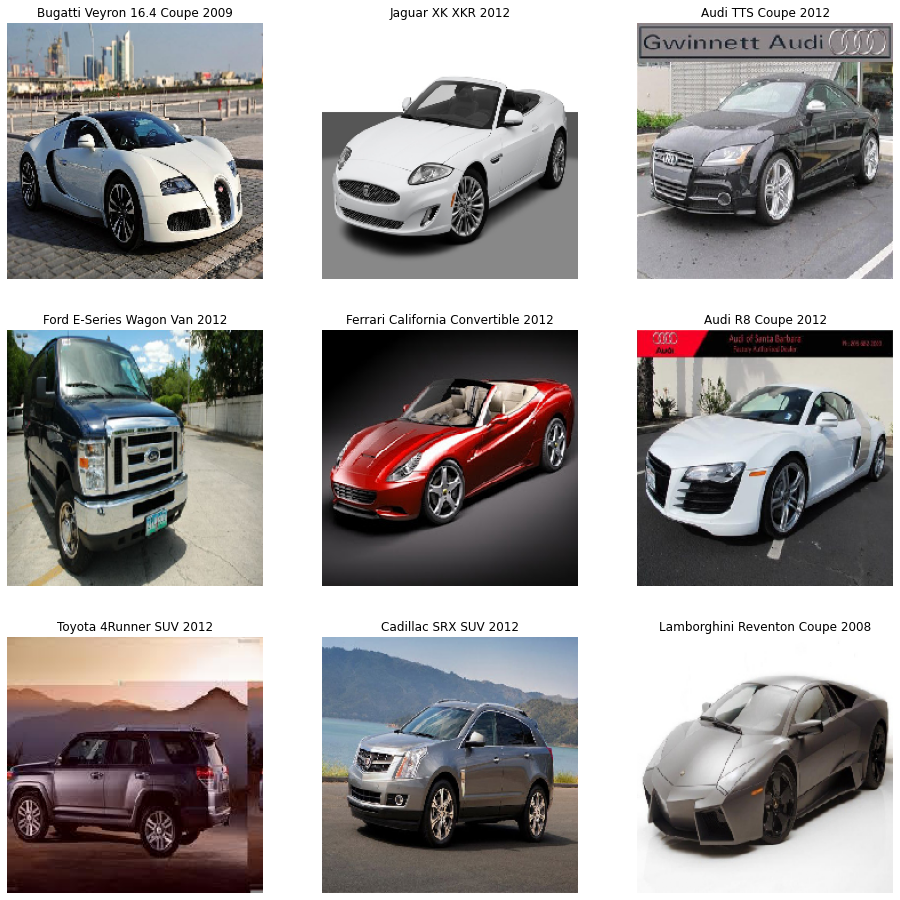

In [ ]:
visualizePreTrain(valSet)

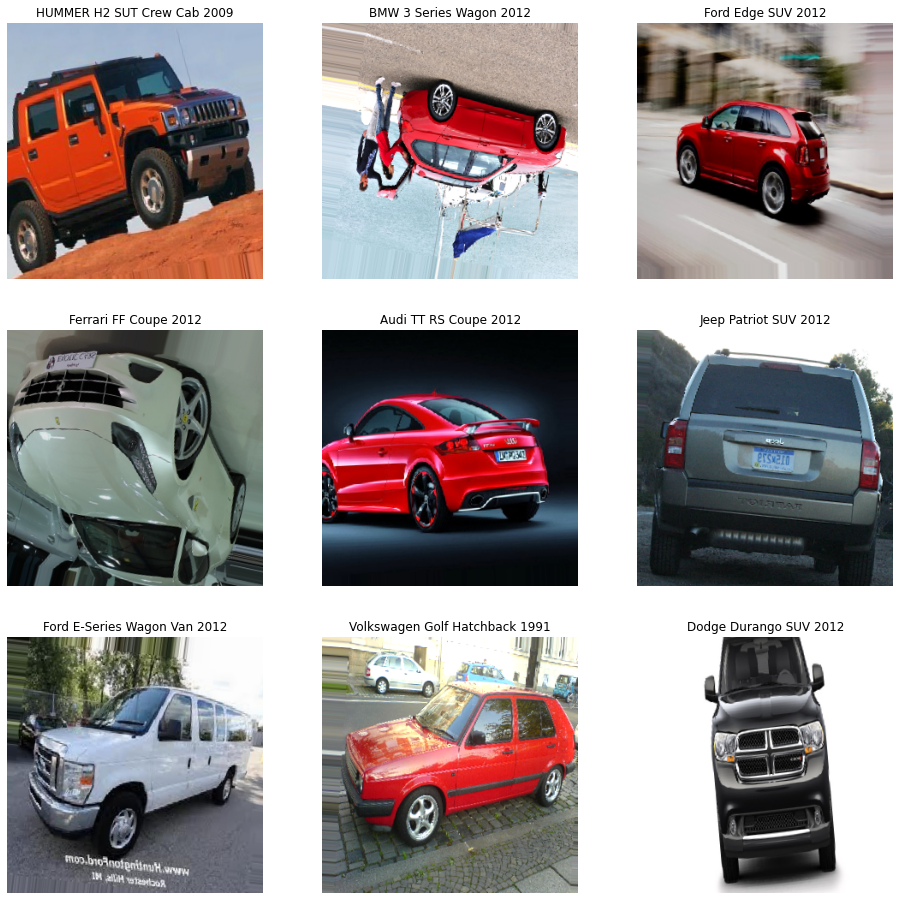

In [19]:
visualizePreTrain(trainSet)

### Loading Test Data

In [ ]:
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DAT_FOLDER = './data'
DAT_PATH = DAT_FOLDER + '/imgs'
TEST_CSV = DAT_FOLDER + '/test.csv'
classes = getClasses()

testdf = pd.read_csv(TEST_CSV)
print(f'Number of test samples: {len(testdf.index)}')

testSet = ImageDataGenerator().flow_from_dataframe(
    dataframe=testdf, 
    directory=DAT_FOLDER, 
    x_col='image', 
    y_col='label', 
    class_mode='raw', 
    shuffle=False,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    color_mode='rgb'
)

Number of test samples: 2428
Found 2428 validated image filenames.


### Model Construction

In [ ]:
# RESULT FOR MOBILENETV2

# baseModel = baseModelF(
#     include_top = False,
#     input_shape = IMG_SIZE + (3,),
#     weights = 'imagenet',
#     pooling = 'avg'
# )

# baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
# RESULT FOR MOBILENETV2

# from tensorflow.keras import Model
# from tensorflow.keras.layers import Dense, Input, Dropout
# from tensorflow.keras.applications.xception import preprocess_input

# baseModel.trainable = True

# inp = Input(IMG_SIZE + (3,))
# x = preprocess_input(inp)
# x = baseModel(x)
# x = Dropout(DROP_RATE)(x)
# x = Dense(N_CLASS, activation='softmax')(x)
# model = Model(inp, x)

# model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_4 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_4 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 196)               251076    
Total params: 2,509,060
Trainable params: 2,474,948
Non-trainable params: 34,112
____________________________________________

In [26]:
baseModel = baseModelF(
    include_top = False,
    input_shape = IMG_SIZE + (3,),
    weights = 'imagenet',
    pooling = 'avg'
)

baseModel.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [27]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.applications.xception import preprocess_input

baseModel.trainable = True

inp = Input(IMG_SIZE + (3,))
x = preprocess_input(inp)
x = baseModel(x)
x = Dropout(DROP_RATE)(x)
x = Dense(N_CLASS, activation='softmax')(x)
model = Model(inp, x)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 299, 299, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 196)               401604    
Total params: 21,263,084
Trainable params: 21,208,556
Non-trainable params: 54,528
__________________________________________

### MobileNetV2

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

optim = Adam(1e-4)
model.compile(optimizer=optim, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

hist = model.fit(trainSet, epochs=50, validation_data=valSet, callbacks=getCallbacks('./models/training_backup/mbv2/checkpoint', 5)[:2])

Epoch 1/50
92/92 [==============================] - 292s 3s/step - loss: 5.2800 - accuracy: 0.0194 - val_loss: 5.1347 - val_accuracy: 0.0364
Epoch 2/50
92/92 [==============================] - 289s 3s/step - loss: 4.5462 - accuracy: 0.0950 - val_loss: 4.4375 - val_accuracy: 0.0800
Epoch 3/50
92/92 [==============================] - 287s 3s/step - loss: 3.6112 - accuracy: 0.2274 - val_loss: 4.0398 - val_accuracy: 0.1149
Epoch 4/50
92/92 [==============================] - 286s 3s/step - loss: 2.8002 - accuracy: 0.3784 - val_loss: 3.9097 - val_accuracy: 0.1566
Epoch 5/50
92/92 [==============================] - 289s 3s/step - loss: 2.2010 - accuracy: 0.5016 - val_loss: 3.5328 - val_accuracy: 0.1997
Epoch 6/50
92/92 [==============================] - 287s 3s/step - loss: 1.7754 - accuracy: 0.5885 - val_loss: 3.0908 - val_accuracy: 0.2613
Epoch 7/50
92/92 [==============================] - 288s 3s/step - loss: 1.4490 - accuracy: 0.6586 - val_loss: 2.8771 - val_accuracy: 0.2981
Epoch 8/50
92

In [ ]:
model.save('./models/final/post_training_mb')
saveHist('./models/final/hist_post_training_mb', hist)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./models/final/post_training/assets


In [ ]:
testLoss, testAcc = model.evaluate(testSet)

19/19 [==============================] - 488s 27s/step - loss: 0.7272 - accuracy: 0.8130


In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.optimizer.lr.assign(5e-5) # LR nhỏ hơn 1 nửa

hist = model.fit(trainSet, epochs=25, validation_data=valSet, callbacks=getCallbacks('./models/training_backup/mbv2/checkpoint2', 3)[:2])

Epoch 1/25
92/92 [==============================] - 284s 3s/step - loss: 0.0327 - accuracy: 0.9946 - val_loss: 0.6848 - val_accuracy: 0.8265
Epoch 2/25
92/92 [==============================] - 274s 3s/step - loss: 0.0282 - accuracy: 0.9948 - val_loss: 0.6958 - val_accuracy: 0.8236
Epoch 3/25
92/92 [==============================] - 275s 3s/step - loss: 0.0280 - accuracy: 0.9950 - val_loss: 0.6942 - val_accuracy: 0.8333
Epoch 4/25
92/92 [==============================] - 273s 3s/step - loss: 0.0254 - accuracy: 0.9960 - val_loss: 0.6721 - val_accuracy: 0.8323
Epoch 5/25
92/92 [==============================] - 274s 3s/step - loss: 0.0237 - accuracy: 0.9963 - val_loss: 0.6787 - val_accuracy: 0.8299
Epoch 6/25
92/92 [==============================] - 270s 3s/step - loss: 0.0229 - accuracy: 0.9962 - val_loss: 0.6675 - val_accuracy: 0.8352
Epoch 7/25
92/92 [==============================] - 272s 3s/step - loss: 0.0246 - accuracy: 0.9953 - val_loss: 0.6559 - val_accuracy: 0.8362
Epoch 8/25
92

In [ ]:
model.save('./models/final/post_training_mb2')
saveHist('./models/final/hist_post_training_mb2', hist)

!zip -r fromKaggle.zip models
getKaggleLink('./fromKaggle.zip')

In [18]:
testLoss, testAcc = model.evaluate(testSet)

19/19 [==============================] - 23s 1s/step - loss: 0.6292 - accuracy: 0.8336


In [19]:
from tensorflow.keras.models import load_model
model.load_weights('./models/training_backup/mbv2/checkpoint2')

In [20]:
bestLoss, bestAcc = model.evaluate(testSet)

19/19 [==============================] - 25s 1s/step - loss: 0.6640 - accuracy: 0.8258


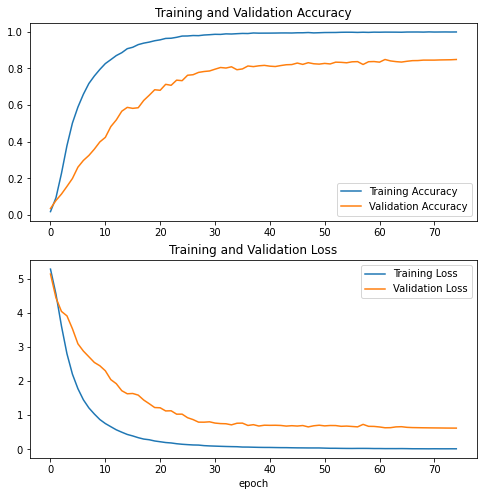

In [7]:
hists = [getHist(i) for i in ['./models/final/hist_post_training_mb', './models/final/hist_post_training_mb2']]
plotTrainResult(hists)

> **CHOOSING POST-TRAINING MOBILENETV2 AFTER 75 EPOCHS TO BE ITS BEST**

### Xception

In [28]:
from tensorflow.keras.optimizers import Adam

optim = Adam(5e-5)
model.compile(optimizer = optim, loss = scce_with_ls, metrics = ['accuracy'])

In [29]:
epochs = [45, 15]
reduceLRps = [4, 2]

for i in range(len(epochs)):
    trainSet, valSet = getTrainValSet(seed = SEED + (i ** 2) * 1000 + (2 * i) * 100)
    
    hist = model.fit(
        trainSet, 
        epochs = sum(epochs[:i+1]), initial_epoch = 0 if i == 0 else sum(epochs[:i]),
        validation_data = valSet,
        callbacks = getCallbacks('./models/training_backup/xcept/checkpoint', reduceLRps[i])[:2]
    )  
    
    saveHist(f'./models/final/hist_post_training_x{i + 1}', hist)
    model.save(f'./models/final/post_training_x{i + 1}')

Found 11694 validated image filenames.
Found 2063 validated image filenames.
Epoch 1/45
244/244 [==============================] - 473s 2s/step - loss: 5.2885 - accuracy: 0.0086 - val_loss: 4.9361 - val_accuracy: 0.0717
Epoch 2/45
244/244 [==============================] - 469s 2s/step - loss: 4.8152 - accuracy: 0.0829 - val_loss: 3.9769 - val_accuracy: 0.2714
Epoch 3/45
244/244 [==============================] - 466s 2s/step - loss: 3.9776 - accuracy: 0.2695 - val_loss: 3.1609 - val_accuracy: 0.4741
Epoch 4/45
244/244 [==============================] - 461s 2s/step - loss: 3.1678 - accuracy: 0.4692 - val_loss: 2.6429 - val_accuracy: 0.6054
Epoch 5/45
244/244 [==============================] - 464s 2s/step - loss: 2.5675 - accuracy: 0.6152 - val_loss: 2.2285 - val_accuracy: 0.6859
Epoch 6/45
244/244 [==============================] - 467s 2s/step - loss: 2.1270 - accuracy: 0.7096 - val_loss: 1.9102 - val_accuracy: 0.7436
Epoch 7/45
244/244 [==============================] - 464s 2s/ste

In [30]:
testLoss, testAcc = model.evaluate(testSet)

51/51 [==============================] - 33s 652ms/step - loss: 1.2667 - accuracy: 0.9102


In [31]:
model.load_weights('./models/training_backup/xcept/checkpoint')
bestLoss, bestAcc = model.evaluate(testSet)

51/51 [==============================] - 28s 540ms/step - loss: 1.2671 - accuracy: 0.9094


In [41]:
from tensorflow.keras.models import load_model
model = load_model('./models/final/post_training_x1', custom_objects = {'scce_with_ls': scce_with_ls})
testLoss1, testAcc1 = model.evaluate(testSet)

51/51 [==============================] - 28s 528ms/step - loss: 1.2694 - accuracy: 0.9082


In [32]:
!zip -r fromKaggle.zip models

  adding: models/ (stored 0%)
  adding: models/training_backup/ (stored 0%)
  adding: models/training_backup/xcept/ (stored 0%)
  adding: models/training_backup/xcept/checkpoint (deflated 48%)
  adding: models/training_backup/xcept/checkpoint.data-00000-of-00001 (deflated 8%)
  adding: models/training_backup/xcept/checkpoint.index (deflated 81%)
  adding: models/final/ (stored 0%)
  adding: models/final/post_training_x2/ (stored 0%)
  adding: models/final/post_training_x2/assets/ (stored 0%)
  adding: models/final/post_training_x2/variables/ (stored 0%)
  adding: models/final/post_training_x2/variables/variables.index (deflated 79%)
  adding: models/final/post_training_x2/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: models/final/post_training_x2/saved_model.pb (deflated 93%)
  adding: models/final/hist_post_training_x2 (deflated 46%)
  adding: models/final/post_training_x1/ (stored 0%)
  adding: models/final/post_training_x1/assets/ (stored 0%)
  adding: models/final

In [43]:
from IPython.display import FileLink
FileLink('./fromKaggle.zip') 

/kaggle/working/fromKaggle.zip

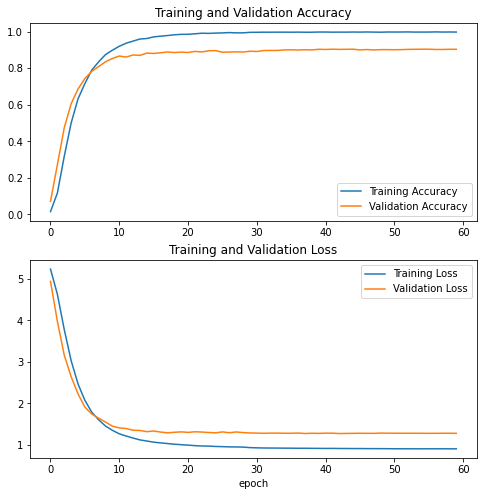

In [2]:
hists = [getHist(i) for i in ['./models/final/hist_post_training_x1', './models/final/hist_post_training_x2']]
plotTrainResult(hists)

> **THE MODEL AFTER ALL TRAINING EPOCHS IS ALSO THE BEST FOR XCEPTION, JUST LIKE FOR MOBILENETV2**

### Evaluation with Top-5 Accuracy

In [12]:
# IN MEMORY LOADING -> MAY LEAD TO OOM
# REMEMBER to set CORRECT CHOICE to load the trainSet in correct IMG_SIZE

X = []
y = testSet.labels

for i in range(testSet.__len__()):
    X.extend(testSet.__getitem__(i)[0])
        
print(f'Found {len(X)}={len(y)} test samples')

Found 2428=2428 test samples


In [7]:
import numpy as np

def getTop1Top5Acc(model):
    top1 = 0.0
    top5 = 0.0    
    class_probs = model.predict(np.array(X))

    for i, l in enumerate(y):
        class_prob = class_probs[i]
        top_values = (-class_prob).argsort()[:5] # - maybe a trick to sort descending?
        if top_values[0] == l:
            top1 += 1.0
        if np.isin(np.array([l]), top_values):
            top5 += 1.0

    print('Top1 Acc:', top1 / len(y))
    print('Top5 Acc:', top5 / len(y))
    return top1, top5

In [8]:
from tensorflow.keras.models import load_model
mbModel = load_model('./models/final/best_mbv2')

In [9]:
# REMEMBER to set choice = 1
mbTop1, mbTop5 = getTop1Top5Acc(mbModel)

Top1 Acc: 0.8336079077429983
Top5 Acc: 0.96334431630972


In [13]:
xModel = load_model('./models/final/best_x', custom_objects = {'scce_with_ls': scce_with_ls})

In [14]:
# REMEMBER to set choice = 2
xTop1, xTop5 = getTop1Top5Acc(xModel)

Top1 Acc: 0.9102141680395387
Top5 Acc: 0.9835255354200988


## Result Visualization

### Preparing Models

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model

N_CLASS = 196
LABEL_SMOOTH = 0.1
classes = getClasses()

MOBILE_IMG_SIZE = (224, 224)
XCEPT_IMG_SIZE = (299, 299)

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
modelMbv2 = load_model('./models/final/best_mbv2')

In [4]:
def scce_with_ls(y, y_hat):
    y = tf.one_hot(tf.cast(y, tf.int32), N_CLASS)
    y = tf.squeeze(y, axis = 1)
    return categorical_crossentropy(y, y_hat, label_smoothing = LABEL_SMOOTH)

modelXcept = load_model('./models/final/best_x', custom_objects = {'scce_with_ls': scce_with_ls})

### Produce Predictions + Confidences for One Input Image

In [29]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

K = 5 # Get top K predictions

# Ref: https://stackoverflow.com/questions/60674501/how-to-make-black-background-in-cv2-puttext-with-python-opencv
def draw_text(img, text, font = cv2.FONT_HERSHEY_SIMPLEX, pos = (10, 10), font_scale = 1, font_thickness = 2, text_color = (0, 255, 0), text_color_bg=(0, 0, 0)):
    x, y = pos
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    cv2.rectangle(img, (pos[0], pos[1] - 5), (x + text_w, y + text_h + 5), text_color_bg, -1)
    cv2.putText(img, text, (x, int(y + text_h + font_scale - 1)), font, font_scale, text_color, font_thickness)
    return text_size

def process(imgPath, trueLabelCode, verbose = 0):
    if verbose != 0:
        plt.figure(figsize = (12, 4))

    imgSizes = (MOBILE_IMG_SIZE, XCEPT_IMG_SIZE)
    models = (modelMbv2, modelXcept)

    imgPathTail = os.path.split(imgPath)[1]
    trueLabel = classes[trueLabelCode]

    if verbose != 0:
        print(f'Processing image {imgPathTail}')
        print(f'True label: {trueLabel}\n')

    orders = ['MobileNetV2', 'Xception']
    res = [imgPathTail, trueLabel]
    for i in range(len(imgSizes)):
        if verbose != 0:
            print(f'Results from {orders[i]}:')

        img = cv2.imread(imgPath)
        inp = cv2.resize(img, imgSizes[i])
        inp = np.expand_dims(inp, axis = 0)

        preds = models[i].predict(inp)[0]
        idx = (-preds).argsort()[:K]

        label = classes[idx[0]]
        label = f'{label}: {preds[idx[0]] * 100:.2f}%'
        draw_text(img, label)

        if verbose != 0:
            plt.subplot(1, 2, i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')

        res.append(img)

        l = []
        for j in range(K):
            c = classes[idx[j]]
            p = preds[idx[j]]
            if verbose != 0:
                print(f'{c} - {p * 100:.2f}%')
            l.append((c, p))
        res.append(l)

        if verbose != 0:
            print('\n', '-' * 30, '\n')

    if verbose != 0:
        plt.show()
    return res

In [17]:
import pandas as pd

code = 8

testdf = pd.read_csv('./data/test.csv')
chosendf = testdf[testdf['label'] == code]
chosendf.head()

,image,label
393,imgs/Aston Martin V8 Vantage Coupe 2012/01276_...,8
438,imgs/Aston Martin V8 Vantage Coupe 2012/02815_...,8
483,imgs/Aston Martin V8 Vantage Coupe 2012/03241_...,8
741,imgs/Aston Martin V8 Vantage Coupe 2012/03828_...,8
835,imgs/Aston Martin V8 Vantage Coupe 2012/07471_...,8


In [19]:
paths = chosendf['image'].tolist()
code = 8
c = classes[code]

for path in paths:
    res = process(f'./data/{path}', code)

    if res[3][0][0] == c and res[3][0][1] > 0.7 and res[5][0][0] == c and res[5][0][1] > 0.7:
        print(path)

imgs/Aston Martin V8 Vantage Coupe 2012/07471_tr.jpg


Processing image 07471_tr.jpg
True label: Aston Martin V8 Vantage Coupe 2012

Results from MobileNetV2:
Aston Martin V8 Vantage Coupe 2012 - 99.12%
Aston Martin V8 Vantage Convertible 2012 - 0.85%
Aston Martin Virage Coupe 2012 - 0.02%
Aston Martin Virage Convertible 2012 - 0.01%
Audi R8 Coupe 2012 - 0.00%

 ------------------------------ 

Results from Xception:
Aston Martin V8 Vantage Coupe 2012 - 96.76%
Aston Martin V8 Vantage Convertible 2012 - 0.43%
Aston Martin Virage Coupe 2012 - 0.08%
Tesla Model S Sedan 2012 - 0.06%
Spyker C8 Coupe 2009 - 0.04%

 ------------------------------ 



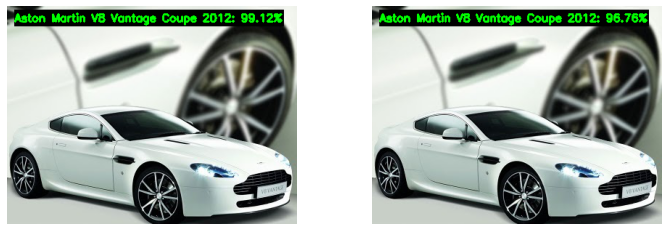

True

In [31]:
res = process('./data/imgs/Aston Martin V8 Vantage Coupe 2012/07471_tr.jpg', code, verbose = 1)
# Using drawTest with fontScale = 0.5

cv2.imwrite('./demo/test_chosen_mbv2.jpg', res[2])
cv2.imwrite('./demo/test_chosen_xcept.jpg', res[4])

### Randomly Demo on Some Test Images

In [9]:
import pandas as pd

N_DEMO = 30

testdf = pd.read_csv('./data/test.csv')
picked = testdf.sample(N_DEMO)
picked.head()

,image,label
1244,imgs/Ford Focus Sedan 2007/05065_tr.jpg,114
43,imgs/Mercedes-Benz S-Class Sedan 2012/08041_tr...,164
1651,imgs/Isuzu Ascender SUV 2008/01132_tr.jpg,142
1197,imgs/Chevrolet Silverado 1500 Regular Cab 2012...,74
540,imgs/Bentley Continental GT Coupe 2012/03162_t...,41


In [11]:
paths = picked['image'].tolist()
codes = picked['label'].tolist()

for i in range(len(picked.index)):
    imgPath = paths[i]
    labelCode = codes[i]

    res = process(f'./data/{imgPath}', labelCode)

    fname = f'o_{os.path.split(imgPath)[1]}'
    cv2.imwrite(f'./demo/outputs_mbv2/{fname}', res[2])
    cv2.imwrite(f'./demo/outputs_xcept/{fname}', res[4])

### Measuring Prediction Running Time 

In [8]:
import pandas as pd
import time
import cv2
import numpy as np

testdf = pd.read_csv('./data/test.csv')
imgPaths = testdf['image'].tolist()

imgSizes = (MOBILE_IMG_SIZE, XCEPT_IMG_SIZE)
models = (modelMbv2, modelXcept)

timeRes = []
for i in range(len(imgSizes)):
    s = 0

    for path in imgPaths:
        img = cv2.imread(f'./data/{path}')
        inp = cv2.resize(img, imgSizes[i])
        inp = np.expand_dims(inp, axis = 0)

        t = time.perf_counter()
        models[i].predict(inp)
        s += time.perf_counter() - t

    timeRes.append(s)

In [9]:
print('Sum:', timeRes)

[146.10105849997763, 207.89992889999485]


In [11]:
timeRes = np.array(timeRes)
n = len(imgPaths)
print(f'Count: {n}')
avgTime = timeRes / len(imgPaths)
print('Average:', avgTime)

Count: 2428
Average: [0.06017342 0.085626  ]
